In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ROOT
import uproot 
import awkward as ak
from pathlib import Path
import os
from tqdm import tqdm

Welcome to JupyROOT 6.24/00


In [3]:
SPVCNN_file_path = "../SPVCNN_outputs_refitted.root"
spvcnn_tree_arrays = uproot.open(SPVCNN_file_path)["refitted_avg"].arrays()


file_path = "/home/dejavu/Projects/vertexing_sample/vertexperformance_AMVF_pu10.root"
truth_tree_arrays = uproot.open(file_path)["Truth_Vertex_PV_Selected"].arrays()
reco_tree_arrays = uproot.open(file_path)["Reco_Vertex"].arrays()


In [4]:
def GetTrkTruthMatchInfo(reco_trk, truth_trk):
    return np.where(ak.to_numpy(reco_trk).reshape(len(reco_trk), 1) == ak.to_numpy(truth_trk))[1]

In [ ]:
# def GetTrkTruthMatchInfo(reco_trk, truth_trk):
#     return np.where(reco_trk.reshape(reco_trk.size, 1) == truth_trk)[1]

In [22]:
vxMatchWeight = 0.7
PV_Classification = np.zeros((4),int)

# N_Event = len(reco_tree_arrays['reco_vtx_fitted_trk_vtxID'])
# # N_Event = 1
for event_id in tqdm(spvcnn_tree_arrays.event_id):
    # event_id = 1134# event_id  debug use
    if event_id % 1000 == 0:
        print(f"{event_id} events processed.")
        
    trk_truth_idx = GetTrkTruthMatchInfo(reco_tree_arrays['reco_vtx_fitted_trk_z0'][event_id], truth_tree_arrays['truth_vtx_fitted_trk_z0'][event_id]) # get trk location in truth array 
    trk_truth_vtx = truth_tree_arrays['truth_vtx_fitted_trk_vtxID'][event_id][trk_truth_idx]
    trk_reco_vtx = reco_tree_arrays['reco_vtx_fitted_trk_vtxID'][event_id]
    trk_pt_sq = ((1./reco_tree_arrays["reco_vtx_fitted_trk_qp"][event_id])*np.sin(reco_tree_arrays["reco_vtx_fitted_trk_theta"][event_id]))**2

    n_truth_vtx = len(truth_tree_arrays['truth_vtx_vz'][event_id])
    n_reco_vtx = len(reco_tree_arrays['reco_vtx_vz'][event_id])

    Raw_RecoVertexMatchInfo = np.zeros((n_reco_vtx, n_truth_vtx, 2), dtype=float)
    for reco_vtx_id in range(n_reco_vtx):
        for truth_vtx_id in range(n_truth_vtx):
            matched_idx = np.intersect1d(np.where(trk_reco_vtx == reco_vtx_id)[0], np.where(trk_truth_vtx == truth_vtx_id)[0])

            Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 0]= ak.sum(reco_tree_arrays['reco_vtx_fitted_trk_trackWeight'][event_id][matched_idx])
            Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 1]= ak.sum(trk_pt_sq[matched_idx])

    RecoVertexMatchInfo = np.copy(Raw_RecoVertexMatchInfo)
    # RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=0)
    # try:
    #     RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
    # except RuntimeWarning: 
    #     print(event_id)
        
    RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
        
    assigned_type = np.array([-1]*(n_reco_vtx))
    for reco_vtx_id in range(n_reco_vtx):      
        if np.isnan(RecoVertexMatchInfo[:,:,0][reco_vtx_id]).all():
            assigned_type[reco_vtx_id] = 3 # labelled as fake 
            continue
            
        max_weight_idx = np.argmax(RecoVertexMatchInfo[:,:,0][reco_vtx_id])
        if RecoVertexMatchInfo[:,:,0][reco_vtx_id][max_weight_idx] > vxMatchWeight and RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] == RecoVertexMatchInfo[:,:,1][:,max_weight_idx].max():
            assigned_type[reco_vtx_id] = 0 # labelled as matched/clean 
            # keep highest sumpt2 vertex labelled as matched/merged 
        elif RecoVertexMatchInfo[:,:,0][reco_vtx_id][max_weight_idx] < vxMatchWeight and RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] == RecoVertexMatchInfo[:,:,1][:,max_weight_idx].max():
            assigned_type[reco_vtx_id] = 1 # labelled as merged
        else: 
            assigned_type[reco_vtx_id] = 2 # labelled as spilt 
            
    stat = np.bincount(assigned_type)
    for PV_type in range(len(stat)):
        PV_Classification[PV_type] += stat[PV_type]



 73%|███████▎  | 730/1000 [00:48<00:18, 14.59it/s]/tmp/ipykernel_9856/3244523460.py:34: RuntimeWarning: invalid value encountered in divide
  RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
100%|██████████| 1000/1000 [01:06<00:00, 14.94it/s]


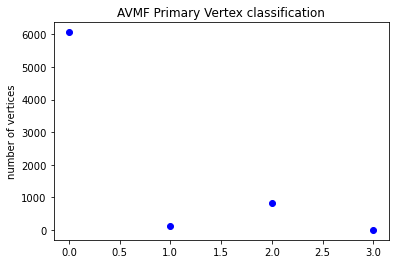

In [24]:
plt.plot(PV_Classification, 'bo')
plt.ylabel('number of vertices')
plt.title("AVMF Primary Vertex classification")
plt.show()

In [31]:
vxMatchWeight = 0.7
spvcnn_PV_Classification = np.zeros((4),int)

# N_Event = len(spvcnn_tree_arrays['reco_vtx_fitted_trk_vtxID'])
# # N_Event = 1
for ii, event_id in tqdm(enumerate(spvcnn_tree_arrays.event_id)):
    # event_id = 1134# event_id  debug use
    if event_id % 1000 == 0:
        print(f"{event_id} events processed.")
        
    trk_truth_idx = GetTrkTruthMatchInfo(spvcnn_tree_arrays['reco_vtx_fitted_trk_z0'][ii], truth_tree_arrays['truth_vtx_fitted_trk_z0'][event_id]) # get trk location in truth array 
    trk_truth_vtx = truth_tree_arrays['truth_vtx_fitted_trk_vtxID'][event_id][trk_truth_idx]
    trk_reco_vtx = spvcnn_tree_arrays['reco_vtx_fitted_trk_vtxID'][ii]
    trk_pt_sq = ((1./spvcnn_tree_arrays["reco_vtx_fitted_trk_qp"][ii])*np.sin(spvcnn_tree_arrays["reco_vtx_fitted_trk_theta"][ii]))**2

    n_truth_vtx = len(truth_tree_arrays['truth_vtx_vz'][event_id])
    n_reco_vtx = len(spvcnn_tree_arrays['refitted_avg_vtx_vz'][ii])

    Raw_RecoVertexMatchInfo = np.zeros((n_reco_vtx, n_truth_vtx, 2), dtype=float)
    for reco_vtx_id in range(n_reco_vtx):
        for truth_vtx_id in range(n_truth_vtx):
            matched_idx = np.intersect1d(np.where(trk_reco_vtx == reco_vtx_id)[0], np.where(trk_truth_vtx == truth_vtx_id)[0])

            Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 0]= ak.sum(spvcnn_tree_arrays['reco_vtx_fitted_trk_trackWeight'][ii][matched_idx])
            Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 1]= ak.sum(trk_pt_sq[matched_idx])

    RecoVertexMatchInfo = np.copy(Raw_RecoVertexMatchInfo)
    # RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=0)
    # try:
    #     RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
    # except RuntimeWarning: 
    #     print(event_id)
        
    RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
        
    assigned_type = np.array([-1]*(n_reco_vtx))
    for reco_vtx_id in range(n_reco_vtx):      
        if np.isnan(RecoVertexMatchInfo[:,:,0][reco_vtx_id]).all():
            assigned_type[reco_vtx_id] = 3 # labelled as fake 
            continue
            
        max_weight_idx = np.argmax(RecoVertexMatchInfo[:,:,0][reco_vtx_id])
        if RecoVertexMatchInfo[:,:,0][reco_vtx_id][max_weight_idx] > vxMatchWeight and RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] == RecoVertexMatchInfo[:,:,1][:,max_weight_idx].max():
            assigned_type[reco_vtx_id] = 0 # labelled as matched/clean 
            # keep highest sumpt2 vertex labelled as matched/merged 
        elif RecoVertexMatchInfo[:,:,0][reco_vtx_id][max_weight_idx] < vxMatchWeight and RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] == RecoVertexMatchInfo[:,:,1][:,max_weight_idx].max():
            assigned_type[reco_vtx_id] = 1 # labelled as merged
        else: 
            assigned_type[reco_vtx_id] = 2 # labelled as spilt 
            
    stat = np.bincount(assigned_type)
    for PV_type in range(len(stat)):
        spvcnn_PV_Classification[PV_type] += stat[PV_type]



0it [00:00, ?it/s]/tmp/ipykernel_9856/3024557601.py:34: RuntimeWarning: invalid value encountered in divide
  RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
1000it [01:10, 14.22it/s]


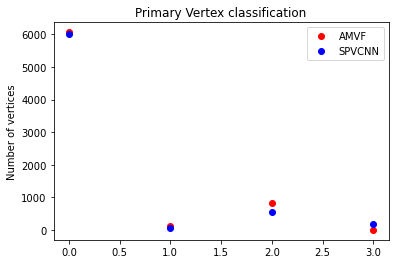

In [33]:
plt.plot(PV_Classification, 'ro', label = 'AMVF' )
plt.plot(spvcnn_PV_Classification, 'bo', label = 'SPVCNN' )
plt.ylabel('Number of vertices')
plt.title("Primary Vertex classification")
plt.legend()
plt.show()

In [35]:
print(PV_Classification)

[6065  127  832    1]


In [34]:
print(spvcnn_PV_Classification)

[6010   74  553  193]
